In [2]:
import os
import pandas as pd
import requests
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams



df = pd.read_csv("CPUUtilization_OneWeek.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2015 entries, 0 to 2014
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Label           2015 non-null   object 
 1   CPUUtilization  2015 non-null   float64
dtypes: float64(1), object(1)
memory usage: 31.6+ KB


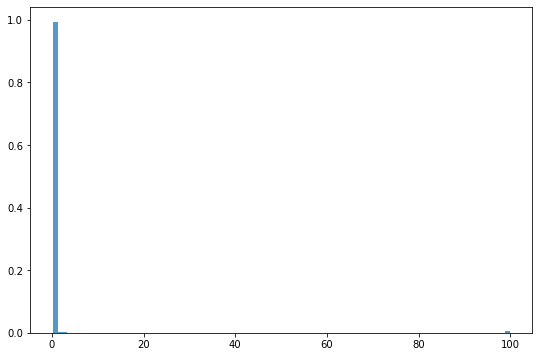

In [3]:
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(df.CPUUtilization  , 100, density=True, alpha=0.75)

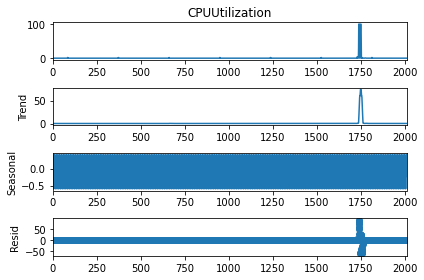

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose

# 계절적 성분 50일로 가정
# extrapolate_trend='freq' : Trend 성분을 만들기 위한 rolling window 때문에 필연적으로 trend, resid에는 Nan 값이 발생하기 때문에, 이 NaN값을 채워주는 옵션이다.
result = seasonal_decompose(df.CPUUtilization, model='additive', two_sided=False, 
                            period=10, extrapolate_trend='freq') 
result.plot()
plt.show()

<AxesSubplot:>

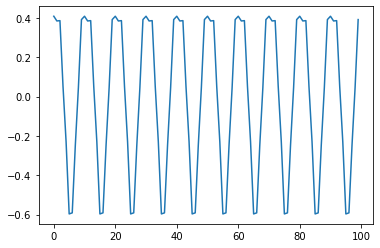

In [5]:
# seasonal 성분은 너무 빼곡하게 보여 다시 확인.
result.seasonal[:100].plot()
# -8 ~ 10 사이를 주기적으로 반복하는게 보인다.

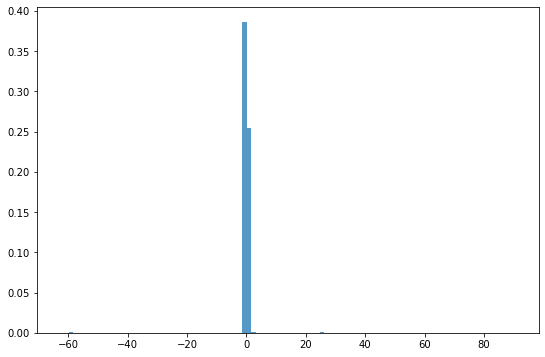

In [6]:
# Residual의 분포 확인
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(result.resid, 100, density=True, alpha=0.75)

In [7]:
# 데이터 전처리
def my_decompose(df, features, freq=5):
    trend = pd.DataFrame()
    seasonal = pd.DataFrame()
    resid = pd.DataFrame()
    
    # 사용할 feature 마다 decompose를 수행한다.
    for f in features:
        result = seasonal_decompose(df[f], model='additive', period=freq, extrapolate_trend=freq)
        trend[f] = result.trend.values
        seasonal[f] = result.seasonal.values
        resid[f] = result.resid.values
        
    return trend, seasonal, resid

# 각 변수별 트렌드/계절적/잔차
tdf, sdf, rdf = my_decompose(df, features=['CPUUtilization'])
tdf.describe()

,CPUUtilization
count,2015.000000
mean,0.916845
std,6.557116
min,0.279928
25%,0.299807
50%,0.306372
75%,0.313378
max,99.708287


In [9]:
# 표준정규화
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(rdf)
print(scaler.mean_)
# [-0.40184982  -0.38035856  -0.39874878  -0.37402025 -195.40645742]

norm_rdf = scaler.transform(rdf)
norm_rdf

[1.7827879e-05]


array([[ 0.03686697],
       [ 0.04128126],
       [-0.01807218],
       ...,
       [-0.02390183],
       [-0.02356719],
       [-0.02118702]])

In [11]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import StandardScaler


# 모델 재현성을 위해 난수 시드설정
tf.random.set_seed(777)
np.random.seed(777)

# 데이터 전처리 - 하이퍼 파라미터
window_size = 10
batch_size = 32
features = ['CPUUtilization']
n_features = len(features)
TRAIN_SIZE = int(len(df)*0.7)

# 데이터 전처리 - 표준정규분포화
scaler = StandardScaler()
scaler = scaler.fit(df.loc[:TRAIN_SIZE,features].values)
scaled = scaler.transform(df[features].values)

# keras TimeseriesGenerator를 이용해 데이터셋 만들기
train_gen = TimeseriesGenerator(
    data = scaled,
    targets = scaled,
    length = window_size,
    stride=1,
    sampling_rate=1,
    batch_size= batch_size,
    shuffle=False,
    start_index=0,
    end_index=None,
)

valid_gen = TimeseriesGenerator(
    data = scaled,
    targets = scaled,
    length = window_size,
    stride=1,
    sampling_rate=1,
    batch_size=batch_size,
    shuffle=False,
    start_index=TRAIN_SIZE,
    end_index=None,
)

print(train_gen[0][0].shape)  # (32, 10, 5)
print(train_gen[0][1].shape)  # (32, 5)


# 모델만들기
# 2개 층의 LSTM으로 인코더 만듬
# RepeatVector는 input을 window_size만큼 복사해줌
model = Sequential([
    # >> 인코더 시작
    LSTM(64, activation='relu', return_sequences=True, input_shape=(window_size, n_features)),
    LSTM(16, activation='relu', return_sequences=False),
    ## << 인코더 끝
    ## >> Bottleneck
    RepeatVector(window_size),
    ## << Bottleneck
    ## >> 디코더 시작
    LSTM(16, activation='relu', return_sequences=True),
    LSTM(64, activation='relu', return_sequences=False),
    Dense(n_features)
    ## << 디코더 끝
])


# 체크포인트
# 학습을 진행하며 validation 결과가 가장 좋은 모델을 저장해둠
checkpoint_path = os.getenv('dev','./KYW/mymodel.ckpt')
checkpoint = ModelCheckpoint(checkpoint_path, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss',
                             verbose=1)

# 얼리스탑
# 학습을 진행하며 validation 결과가 나빠지면 스톱. patience 횟수만큼은 참고 지켜본다
early_stop = EarlyStopping(monitor='val_loss', patience=5)

model.compile(loss='mae', optimizer='adam',metrics=["mae"])


hist = model.fit(train_gen, 
          validation_data=valid_gen,
          steps_per_epoch=len(train_gen),
          validation_steps=len(valid_gen),
          epochs=50, 
          callbacks=[checkpoint, early_stop])
          

model.load_weights(checkpoint_path)

(32, 10, 1)
(32, 1)
Epoch 1/50
62/63 [============================>.] - ETA: 0s - loss: 5.4043 - mae: 5.4043
Epoch 1: val_loss improved from inf to 17.59109, saving model to ./KYW\mymodel.ckpt
63/63 [==============================] - 7s 28ms/step - loss: 5.3189 - mae: 5.3189 - val_loss: 17.5911 - val_mae: 17.5911
Epoch 2/50
61/63 [============================>.] - ETA: 0s - loss: 5.4972 - mae: 5.4972
Epoch 2: val_loss improved from 17.59109 to 17.18690, saving model to ./KYW\mymodel.ckpt
63/63 [==============================] - 1s 16ms/step - loss: 5.3296 - mae: 5.3296 - val_loss: 17.1869 - val_mae: 17.1869
Epoch 3/50
60/63 [===========================>..] - ETA: 0s - loss: 5.4048 - mae: 5.4048
Epoch 3: val_loss did not improve from 17.18690
63/63 [==============================] - 1s 16ms/step - loss: 5.1826 - mae: 5.1826 - val_loss: 17.5969 - val_mae: 17.5969
Epoch 4/50
60/63 [===========================>..] - ETA: 0s - loss: 5.4320 - mae: 5.4320
Epoch 4: val_loss improved from 17.18

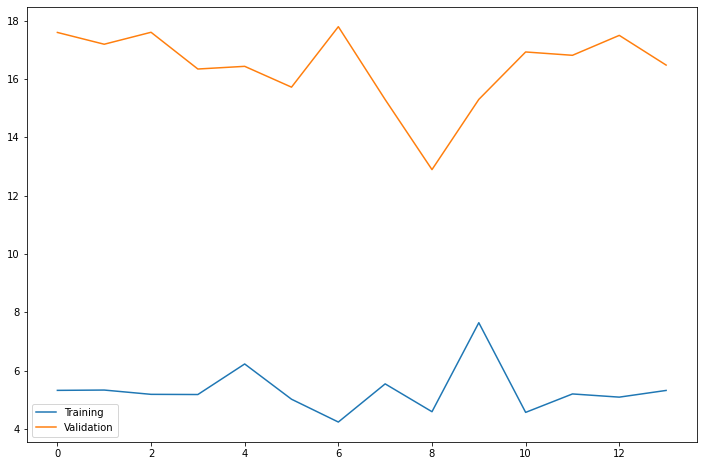

In [14]:
fig = plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'], label='Training')
plt.plot(hist.history['val_loss'], label='Validation')
plt.legend()

63/63 [==============================] - 1s 4ms/step


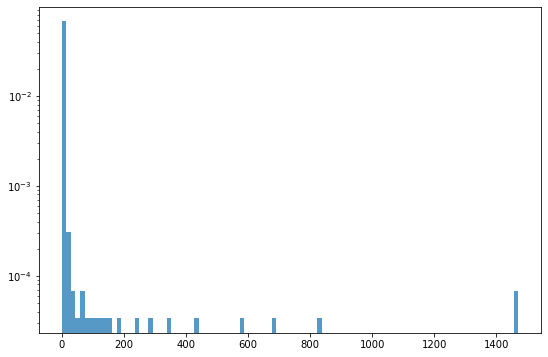

In [15]:
# 예측 결과를 pred 로, 실적 데이터를 real로 받습니다
pred = model.predict(train_gen)
real = scaled[window_size:]

mae_loss = np.mean(np.abs(pred-real), axis=1)

# 샘플 개수가 많기 때문에 y축을 로그 스케일로 그립니다
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(mae_loss, 100, density=True, alpha=0.75, log=True)

In [17]:
import copy

test_df = copy.deepcopy(df.loc[window_size:]).reset_index(drop=True)
test_df['Loss'] = mae_loss
threshold = 3
test_df.loc[test_df.Loss>threshold]

,Label,CPUUtilization,Loss
76,2022-11-01 11:50,2.328925,17.028390
364,2022-11-02 11:50,2.235593,16.249524
652,2022-11-03 11:50,2.234991,16.247709
940,2022-11-04 11:50,2.323271,16.990124
1228,2022-11-05 11:50,2.267250,16.512906
1516,2022-11-06 11:50,2.231261,16.217239
1720,2022-11-07 4:50,4.202843,32.769338
1728,2022-11-07 5:30,29.035593,240.504678
1729,2022-11-07 5:35,99.830508,689.890148
1730,2022-11-07 5:40,99.803279,433.925948


In [18]:
threshold = 0.3
test_df.loc[test_df.Loss>threshold]

,Label,CPUUtilization,Loss
41,2022-11-01 8:55,0.365777,0.430131
52,2022-11-01 9:50,0.367287,0.549233
76,2022-11-01 11:50,2.328925,17.028390
89,2022-11-01 12:55,0.367834,0.563734
183,2022-11-01 20:45,0.336195,0.301543
...,...,...,...
1947,2022-11-07 23:45,0.403485,0.382452
1949,2022-11-07 23:55,0.397471,0.340819
1987,2022-11-08 3:05,0.399491,0.337830
1993,2022-11-08 3:35,0.399747,0.359990


C:\Users\nsa01\anaconda3\lib\site-packages\matplotlib\lines.py:189: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return Path(verts[markevery], _slice_or_none(codes, markevery))


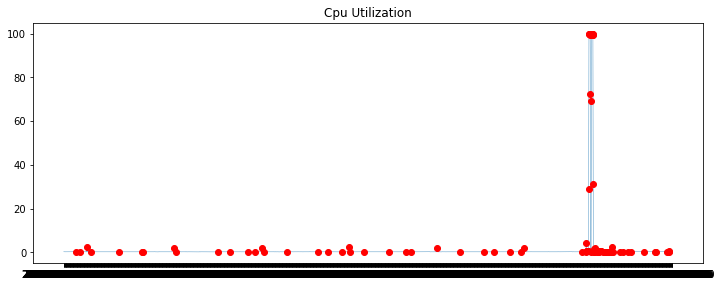

In [19]:
fig = plt.figure(figsize=(12,15))


# 거래량 그래프입니다
ax = fig.add_subplot(312)
ax.set_title('Cpu Utilization')
plt.plot(test_df.Label, test_df.CPUUtilization, linewidth=0.5, alpha=0.75, label='Volume')
plt.plot(test_df.Label, test_df.CPUUtilization, 'or', markevery=[mae_loss>threshold])
